# 成長管モデルのパラメータ推定

In [ ]:
!pip install git+https://github.com/noshita/growing_tube_model_estimation.git

In [1]:
import os, glob, re, sys
import importlib

import numpy as np
import pandas as pd

from scipy.spatial.transform import Rotation as R
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import plotly.graph_objects as go


# if not os.path.join('..', 'src') in sys.path:
#     sys.path.append(os.path.join('..', 'src'))

from growing_tube_model_estimation.io import read_mv3d
from growing_tube_model_estimation.growing_tube import estimate_gt_e_and_r0, fit_bspline_curve, gen_knots

## 関数定義

In [2]:
def gt_generating_spiral(s, e, c, t, r0 = 1, p0 = np.zeros(3), R0 = np.identity(3)):
    """
    Parameters
    ----------
    s : float
        growth stage
    e : float
        expansion rate
    c : float
        curvature
    t : float
        torsion
    r0 : float
        initial tube radius
    p0 : float, optional
        initial tube position, by default np.zeros(3)
    R0 : float, optional
        initial tube orientation, by default np.identity(3)
    
    Returns
    -------
    x : 

    """
    E_g = e
    C_g = c
    T_g = t

    r = r0 * np.exp(E_g * s)
    D = np.sqrt(C_g**2 + T_g**2)

    ED3E2pD2 = E_g * D**3 * (E_g**2 + D**2)
    expEs = np.exp(E_g * s)
    sinDs = np.sin(D * s)
    cosDs = np.cos(D * s)

    P = (
        r0
        * D
        * (
            (
                (D**2) * (T_g**2)
                + (E_g**2) * (T_g**2)
                + C_g**2 * E_g**2 * cosDs
                + E_g * D * (C_g**2) * sinDs
            )
            * expEs
            - D**2 * (E_g**2 + T_g**2)
        )
        / ED3E2pD2
    )
    Q = (
        r0
        * C_g
        * D
        * E_g
        * (-expEs * (C_g**2 + T_g**2) * cosDs + D * (D + expEs * E_g * sinDs))
        / ED3E2pD2
    )
    R = (
        r0
        * C_g
        * T_g
        * D
        * (
            ((E_g**2) + (D**2) - (E_g**2) * cosDs - E_g * D * sinDs) * expEs
            - D**2
        )
        / ED3E2pD2
    )

    PMat = p0 + np.transpose(np.dot(R0, np.array([P, Q, R])))

    return PMat


def estimate_gt_c_and_t(arclength_parameters, coords, e, r0, initial_c = 0, initial_t = 0, bounds=None,debug = False):

    s = np.log(1+(e*arclength_parameters)/r0)/e

    def gt_generating_spiral_wrapper(s, c, t, p0_x, p0_y, p0_z, R0_x, R0_y, R0_z):
        p0 = np.array([p0_x, p0_y, p0_z])
        R0 = R.from_rotvec(np.array([R0_x, R0_y, R0_z])).as_matrix()
        PMat = gt_generating_spiral(s, e, c, t, r0 = r0, p0 = p0, R0 = R0)
        return PMat.reshape(-1)
    
    p_opt, p_cov = curve_fit(
        gt_generating_spiral_wrapper, s, coords.reshape(-1), 
        p0 = [initial_c, initial_t, 0, 0, 0, 0, 0, 0],
        bounds = bounds
        )

    c, t, p0_x, p0_y, p0_z, R0_x, R0_y, R0_z = p_opt
    p0 = np.array([p0_x, p0_y, p0_z])
    R0 = R.from_rotvec(np.array([R0_x, R0_y, R0_z])).as_matrix()

    if debug:
        return c, t, p0, R0, p_cov
    
    return c, t, p0, R0

## データの読み込み

In [ ]:
# for Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [32]:
FILE_PATH = "../data/examples/Ainohelix_editha_01.mv3d"

coords, thicknesses, arclength_parameters = read_mv3d(FILE_PATH, read_as = "growth_trajectory")

line_num:  1
point_num:  3476
inter_num:  0


## パラメータ推定

E:  0.03832076222834232 r0:  0.9141425383330772


(0.0, 6.4762774)

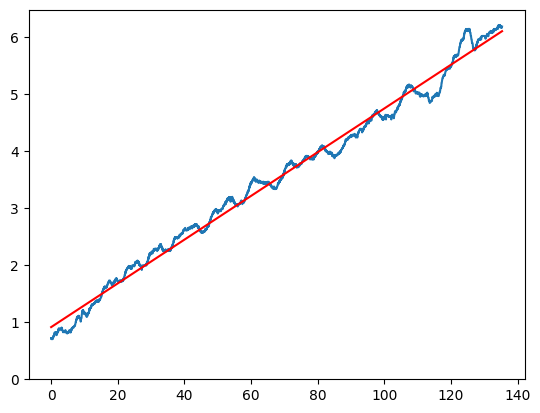

In [33]:
e, r0 = estimate_gt_e_and_r0(arclength_parameters, thicknesses)
print("E: ",e, "r0: ", r0)

arclength_end = np.max(arclength_parameters)
plt.plot(arclength_parameters, thicknesses)
plt.plot([0, arclength_end], [r0, r0+e*arclength_end], "r")
plt.ylim(bottom = 0)

In [34]:
k=6
n_knots = 10

knots = gen_knots(0, arclength_end, n_knots, k+1)
b, arclength_parameters_updated = fit_bspline_curve(arclength_parameters, coords, knots, k = k)

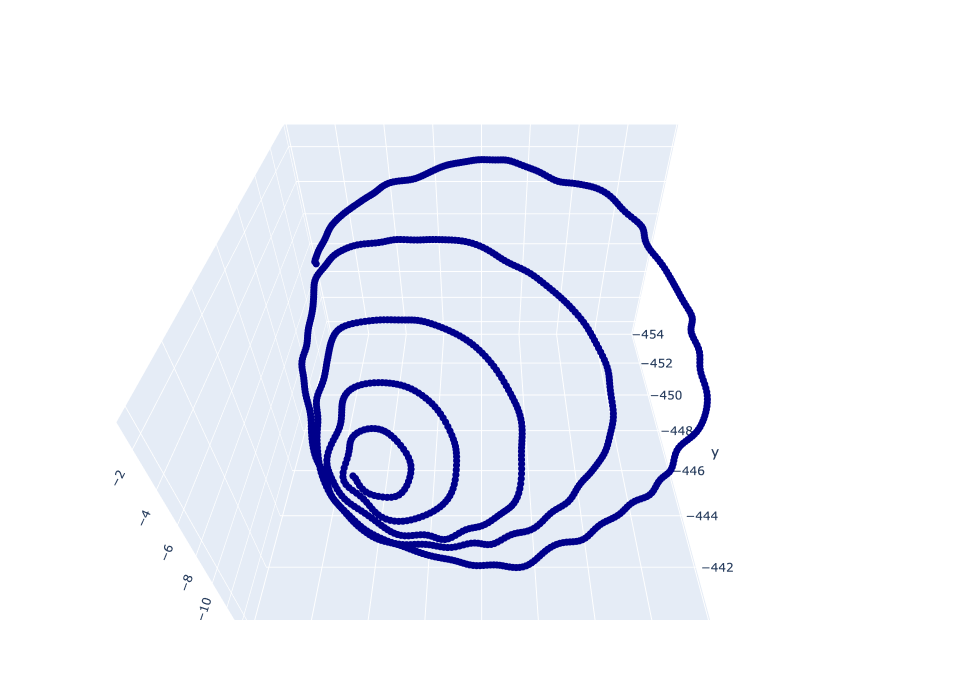

In [35]:
x, y, z = np.transpose(b(np.linspace(arclength_parameters_updated[0],arclength_parameters_updated[-1],1000)))

fig = go.Figure(data= go.Scatter3d(
    x=x, y=y, z=z,
    marker=dict(
        size=2,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()

E:  0.0408975024058625 r0:  0.9141425361583376


(0.0, 6.4762774)

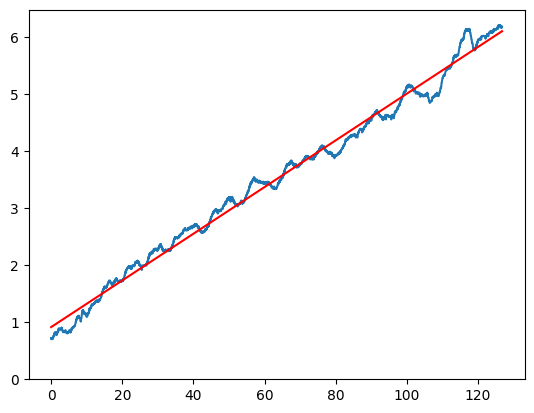

In [36]:
e, r0 = estimate_gt_e_and_r0(arclength_parameters_updated, thicknesses)
print("E: ",e, "r0: ", r0)

arclength_end = np.max(arclength_parameters_updated)
plt.plot(arclength_parameters_updated, thicknesses)
plt.plot([0, arclength_end], [r0, r0+e*arclength_end], "r")
plt.ylim(bottom = 0)

In [37]:
c, t, p0, R0 = estimate_gt_c_and_t(arclength_parameters_updated, coords, e, r0, initial_c = 0.5, initial_t = 0.05)

## 結果の可視化・確認

In [38]:
print("E: ", e, "C: ", c, "T: ", t)
print( "r0: ", r0, "p0: ", p0)
print("R0: ", R0)

E:  0.0408975024058625 C:  0.585483069469507 T:  -0.04479207451918928
r0:  0.9141425361583376 p0:  [-402.40470915 -440.52573332   -4.02524978]
R0:  [[ 0.45583105  0.80833891  0.37256712]
 [-0.64959832  0.01597747  0.76010969]
 [ 0.60847356 -0.58850058  0.53237862]]


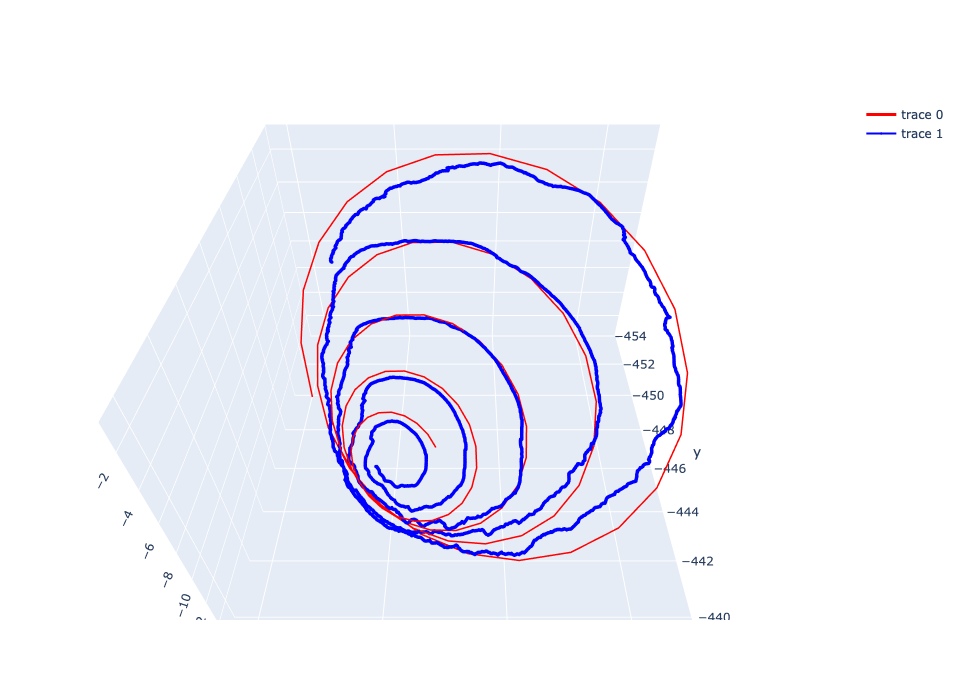

In [39]:
s = np.log(1+(e*arclength_parameters)/r0)/e
x, y, z = gt_generating_spiral(np.linspace(0, s[-1], 100), e, c, t, r0=r0,p0=p0, R0=R0).T

x_coords, y_coords, z_coords = coords.T

fig = go.Figure(data= [
    go.Scatter3d(
    x=x, y=y, z=z,
    mode="lines",
    line=dict(
        color='red',
        width=3
    )
),
go.Scatter3d(
    x=x_coords, y=y_coords, z=z_coords,
    marker=dict(
        size=1,
        color="blue"
    )
)
])

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()